# Imports

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T

import glob
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
    
src_abspath = os.path.abspath('..')

if src_abspath not in sys.path:
    sys.path.append(src_abspath)


In [3]:
from src.forecasters.datasets import NASAIMSRawDataset, NASAIMSSpectrumDataset, NASAIMSMelDataset, get_nasa_stats

# Подгрузка конфига

In [4]:
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg)

{'data': {'window_size': 1024, 'overlap': 768, 'spectral': False, 'sample_rate': 20000, 'f_max': 5000, 'n_mels': 64, 'chunk_size': 8192, 'chunk_overlap': 6144}}


In [5]:
DATA_PATH = "../data/2nd_test/"

files = os.listdir(DATA_PATH)
files = sorted(files)

data = pl.read_csv(Path(DATA_PATH) / files[0], has_header=False, separator='\t')

# Dataset example

## Тест датасета на сыром сигнале

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Raw Pair Dataset: 295 files, 76 pairs per file.
Raw Pair Dataset: 295 files, 76 pairs per file.
Raw Pair Dataset: 295 files, 76 pairs per file.
Raw Pair Dataset: 295 files, 76 pairs per file.
Raw Pair Dataset: 688 files, 76 pairs per file.
Raw Pair Dataset: 688 files, 76 pairs per file.
Raw Pair Dataset: 688 files, 76 pairs per file.
Raw Pair Dataset: 688 files, 76 pairs per file.


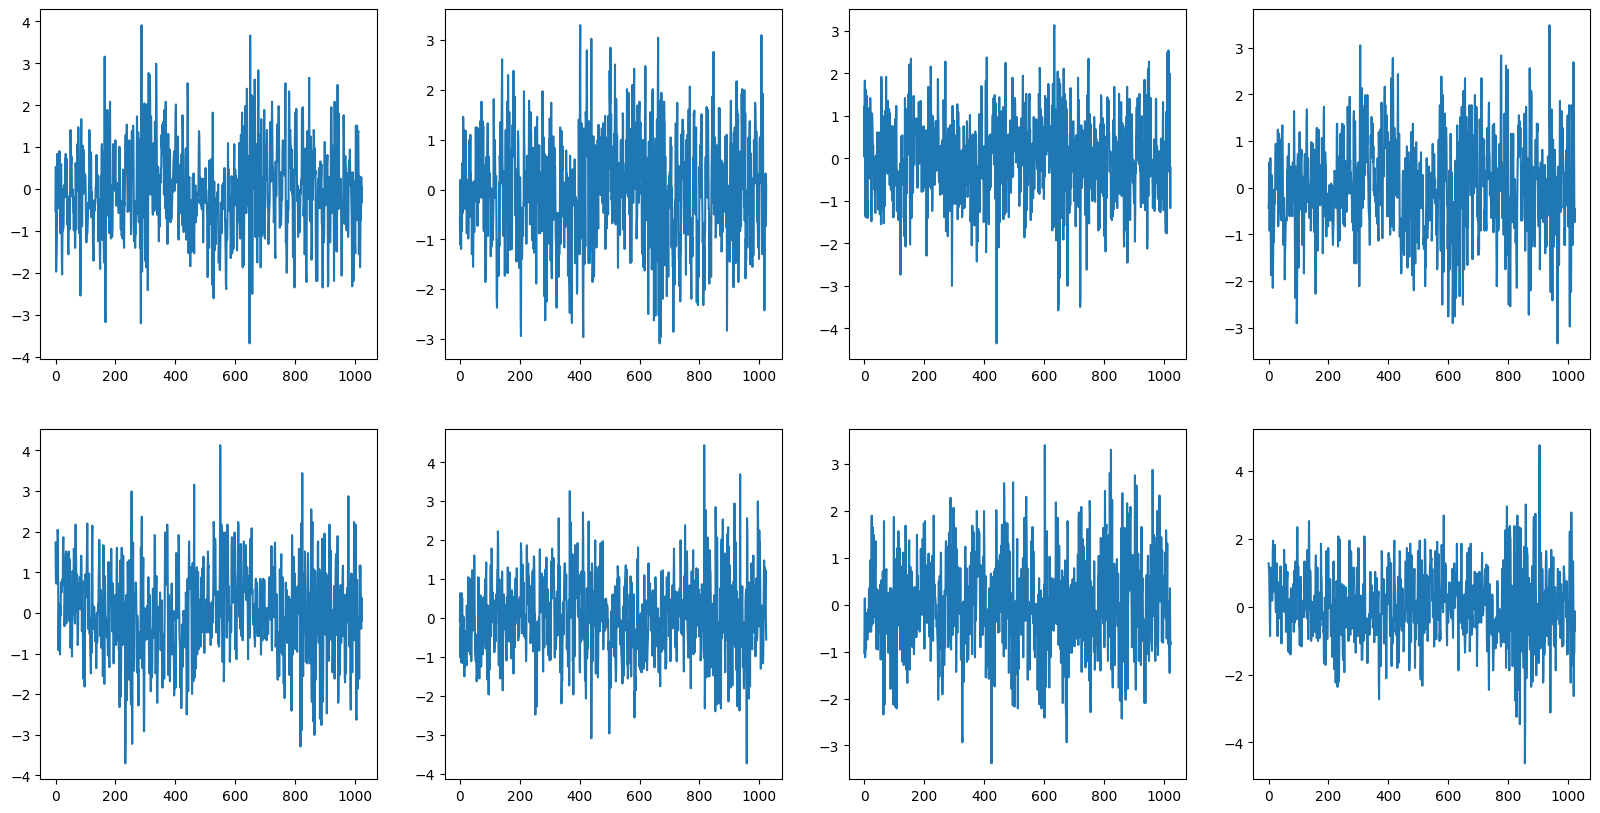

In [10]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

test_frac = 0.7
test_files = [Path(DATA_PATH) / el for el in files[-int(len(files) * test_frac):]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

test_ds0 = NASAIMSRawDataset(test_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
test_ds1 = NASAIMSRawDataset(test_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
test_ds2 = NASAIMSRawDataset(test_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
test_ds3 = NASAIMSRawDataset(test_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
healthy_idx = np.random.randint(len(ds0))

ax[0][0].plot(ds0[healthy_idx][0].ravel())
ax[0][1].plot(ds1[healthy_idx][0].ravel())
ax[0][2].plot(ds2[healthy_idx][0].ravel())
ax[0][3].plot(ds3[healthy_idx][0].ravel())

test_idx = np.random.randint(len(test_ds0[0]))
ax[1][0].plot(test_ds0[test_idx][1].ravel())
ax[1][1].plot(test_ds1[test_idx][1].ravel())
ax[1][2].plot(test_ds2[test_idx][1].ravel())
ax[1][3].plot(test_ds3[test_idx][1].ravel())

## Тест датасета на спектре сигнала

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Spectrum Pair Dataset: 295 files.
Spectrum Pair Dataset: 295 files.
Spectrum Pair Dataset: 295 files.
Spectrum Pair Dataset: 295 files.
Spectrum Pair Dataset: 688 files.
Spectrum Pair Dataset: 688 files.
Spectrum Pair Dataset: 688 files.
Spectrum Pair Dataset: 688 files.


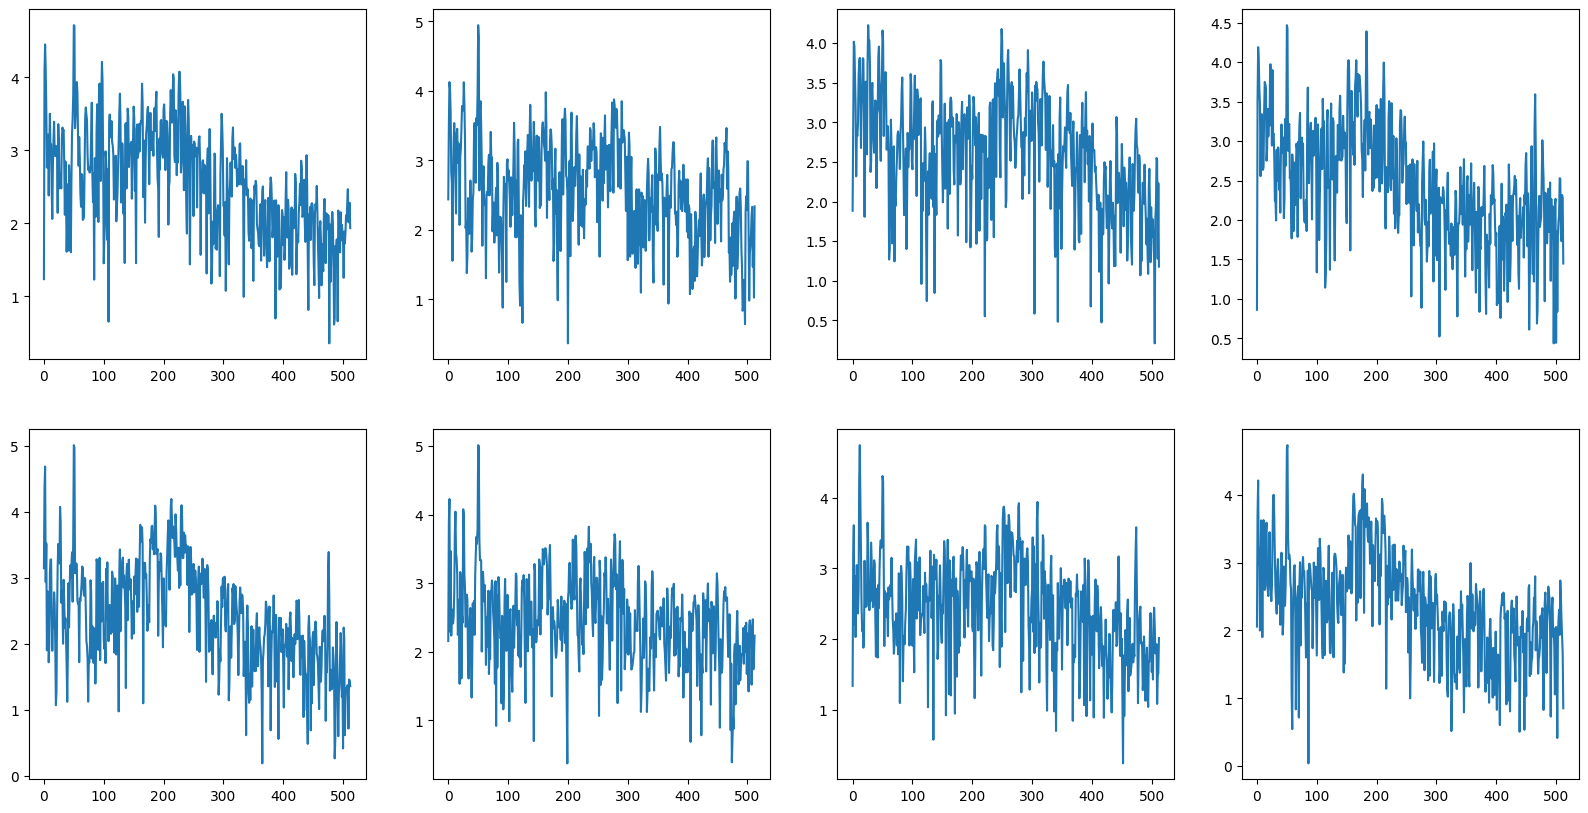

In [11]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

test_frac = 0.7
test_files = [Path(DATA_PATH) / el for el in files[-int(len(files) * test_frac):]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

test_ds0 = NASAIMSSpectrumDataset(test_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
test_ds1 = NASAIMSSpectrumDataset(test_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
test_ds2 = NASAIMSSpectrumDataset(test_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
test_ds3 = NASAIMSSpectrumDataset(test_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
healthy_idx = np.random.randint(len(ds0))

ax[0][0].plot(ds0[healthy_idx][0].ravel())
ax[0][1].plot(ds1[healthy_idx][0].ravel())
ax[0][2].plot(ds2[healthy_idx][0].ravel())
ax[0][3].plot(ds3[healthy_idx][0].ravel())

test_idx = np.random.randint(len(test_ds0[0]))
ax[1][0].plot(test_ds0[test_idx][1].ravel())
ax[1][1].plot(test_ds1[test_idx][1].ravel())
ax[1][2].plot(test_ds2[test_idx][1].ravel())
ax[1][3].plot(test_ds3[test_idx][1].ravel())

## Тест датасета на спектрограммах

In [12]:
healthy_frac = 0.4
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

test_frac = 0.1
test_files = [Path(DATA_PATH) / el for el in files[-int(len(files) * test_frac):]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSMelDataset(healthy_files, 0, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b1_mean"][0], z_norm_params["b1_std"][0]
                       )
ds1 = NASAIMSMelDataset(healthy_files, 1, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b2_mean"][0], z_norm_params["b2_std"][0]
                       )
ds2 = NASAIMSMelDataset(healthy_files, 2, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b3_mean"][0], z_norm_params["b3_std"][0]
                       )
ds3 = NASAIMSMelDataset(healthy_files, 3, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b4_mean"][0], z_norm_params["b4_std"][0]
                       )

test_ds0 = NASAIMSMelDataset(test_files, 0, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b1_mean"][0], z_norm_params["b1_std"][0]
                       )
test_ds1 = NASAIMSMelDataset(test_files, 1, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b2_mean"][0], z_norm_params["b2_std"][0]
                       )
test_ds2 = NASAIMSMelDataset(test_files, 2, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b3_mean"][0], z_norm_params["b3_std"][0]
                       )
test_ds3 = NASAIMSMelDataset(test_files, 3, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b4_mean"][0], z_norm_params["b4_std"][0]
                       )

Reading files:   0%|          | 0/393 [00:00<?, ?it/s]

Mel Pair Dataset: 393 files, 6 pairs per file.
Mel Pair Dataset: 393 files, 6 pairs per file.
Mel Pair Dataset: 393 files, 6 pairs per file.
Mel Pair Dataset: 393 files, 6 pairs per file.
Mel Pair Dataset: 98 files, 6 pairs per file.
Mel Pair Dataset: 98 files, 6 pairs per file.
Mel Pair Dataset: 98 files, 6 pairs per file.
Mel Pair Dataset: 98 files, 6 pairs per file.


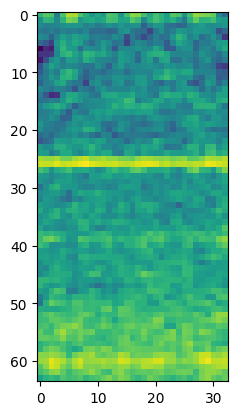

In [14]:
rand_idx = np.random.randint(len(test_ds0))
plt.imshow(ds0[rand_idx][0].permute(1, 2, 0))

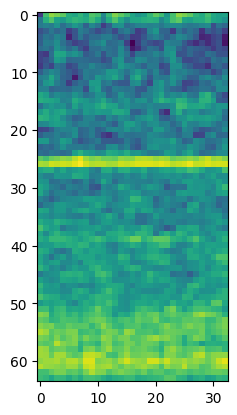

In [15]:
rand_idx = np.random.randint(len(test_ds0))
plt.imshow(ds0[rand_idx][1].permute(1, 2, 0))

# Тренировка моделей

## Срой сигнал

In [6]:
from src.forecasters import train_loop
from src.forecasters.datasets import NASAIMSRawDataset
from src.unet1d import model, load_save
from torch.utils.data import ConcatDataset

In [7]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

val_frac = 0.2
val_files = [Path(DATA_PATH) / el for el in files[int(len(files) * healthy_frac) :  int(len(files) * (healthy_frac + val_frac))]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
cds1 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

val_ds0 = NASAIMSRawDataset(val_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
val_ds1 = NASAIMSRawDataset(val_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
val_ds2 = NASAIMSRawDataset(val_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
val_ds3 = NASAIMSRawDataset(val_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

train_ds = ConcatDataset([ds0, ds1, ds2, ds3])
val_ds = ConcatDataset([val_ds0, val_ds1, val_ds2, val_ds3])

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/197 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/197 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/197 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/197 [00:00<?, ?it/s]

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
fc_model = model.UNet1D(n_blocks=1, ch_mults=(1, 2, 4), is_attn=(False, True, True), n_channels=16).to(device)
epochs = 10
lr = 5e-4
batch_size = 32

optimizer = torch.optim.AdamW(lr=lr, params=fc_model.parameters())



fc_model, history = train_loop.forecast_train_loop(fc_model, train_ds, val_ds, optimizer, epochs, device, batch_size, info_interval=2,
                                                  save_func=load_save.save_model_checkpoint)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/2803 [00:00<?, ?it/s]

Validation:   0%|          | 0/1872 [00:00<?, ?it/s]

Training:   0%|          | 0/2803 [00:00<?, ?it/s]

Validation:   0%|          | 0/1872 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Спектр сигнала

In [6]:
from src.forecasters import train_loop_unet1d
from src.forecasters.datasets import NASAIMSSpectrumDataset
from src.unet1d import model, load_save
from torch.utils.data import ConcatDataset

In [7]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

val_frac = 0.2
val_files = [Path(DATA_PATH) / el for el in files[int(len(files) * healthy_frac) :  int(len(files) * (healthy_frac + val_frac))]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

val_ds0 = NASAIMSSpectrumDataset(val_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
val_ds1 = NASAIMSSpectrumDataset(val_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
val_ds2 = NASAIMSSpectrumDataset(val_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
val_ds3 = NASAIMSSpectrumDataset(val_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

train_ds = ConcatDataset([ds0, ds1, ds2, ds3])
val_ds = ConcatDataset([val_ds0, val_ds1, val_ds2, val_ds3])

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Loading spectrum data:   0%|          | 0/295 [00:00<?, ?it/s]

Loading spectrum data:   0%|          | 0/295 [00:00<?, ?it/s]

Loading spectrum data:   0%|          | 0/295 [00:00<?, ?it/s]

Loading spectrum data:   0%|          | 0/295 [00:00<?, ?it/s]

Loading spectrum data:   0%|          | 0/197 [00:00<?, ?it/s]

Loading spectrum data:   0%|          | 0/197 [00:00<?, ?it/s]

Loading spectrum data:   0%|          | 0/197 [00:00<?, ?it/s]

Loading spectrum data:   0%|          | 0/197 [00:00<?, ?it/s]

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
fc_model = model.UNet1D(n_blocks=1, ch_mults=(1, 2, 4), is_attn=(False, True, True), n_channels=16).to(device)
epochs = 1
lr = 5e-4
batch_size = 32

optimizer = torch.optim.AdamW(lr=lr, params=fc_model.parameters())



fc_model, history = train_loop_unet1d.forecast_train_loop(fc_model, train_ds, val_ds, optimizer, epochs, device, batch_size, info_interval=2, name="forecast_model_spectrum",
                                                  save_func=load_save.save_model_checkpoint))

  0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/2803 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Спектрограмма

In [10]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

val_frac = 0.2
val_files = [Path(DATA_PATH) / el for el in files[-int(len(files) * val_frac):]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSMelDataset(healthy_files, 0, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b1_mean"][0], z_norm_params["b1_std"][0]
                       )
ds1 = NASAIMSMelDataset(healthy_files, 1, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b2_mean"][0], z_norm_params["b2_std"][0]
                       )
ds2 = NASAIMSMelDataset(healthy_files, 2, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b3_mean"][0], z_norm_params["b3_std"][0]
                       )
ds3 = NASAIMSMelDataset(healthy_files, 3, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b4_mean"][0], z_norm_params["b4_std"][0]
                       )

val_ds0 = NASAIMSMelDataset(val_files, 0, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b1_mean"][0], z_norm_params["b1_std"][0]
                       )
val_ds1 = NASAIMSMelDataset(val_files, 1, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b2_mean"][0], z_norm_params["b2_std"][0]
                       )
val_ds2 = NASAIMSMelDataset(val_files, 2, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b3_mean"][0], z_norm_params["b3_std"][0]
                       )
val_ds3 = NASAIMSMelDataset(val_files, 3, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b4_mean"][0], z_norm_params["b4_std"][0]
                       )

train_ds = ConcatDataset([ds0, ds1, ds2, ds3])
val_ds = ConcatDataset([val_ds0, val_ds1, val_ds2, val_ds3])

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Loading mel data:   0%|          | 0/295 [00:00<?, ?it/s]

Loading mel data:   0%|          | 0/295 [00:00<?, ?it/s]

Loading mel data:   0%|          | 0/295 [00:00<?, ?it/s]

Loading mel data:   0%|          | 0/295 [00:00<?, ?it/s]

Loading mel data:   0%|          | 0/196 [00:00<?, ?it/s]

Loading mel data:   0%|          | 0/196 [00:00<?, ?it/s]

Loading mel data:   0%|          | 0/196 [00:00<?, ?it/s]

Loading mel data:   0%|          | 0/196 [00:00<?, ?it/s]

# TCN on RAW

In [12]:
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config_forecast")
    print(cfg)

{'data': {'pre_horizon': 1024, 'horizon': 128, 'overlap': 128, 'spectral': False, 'sample_rate': 20000}}


In [13]:
from src.forecasters.datasets import NASAIMSRawForecastDataset, get_nasa_stats
from torch.utils.data import ConcatDataset
from src.tcn import model, load_save
from src.forecasters import train_loop

In [14]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

val_frac = 0.2
val_files = [Path(DATA_PATH) / el for el in files[int(len(files) * healthy_frac) :  int(len(files) * (healthy_frac + val_frac))]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSRawForecastDataset(healthy_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSRawForecastDataset(healthy_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSRawForecastDataset(healthy_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSRawForecastDataset(healthy_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

val_ds0 = NASAIMSRawForecastDataset(val_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
val_ds1 = NASAIMSRawForecastDataset(val_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
val_ds2 = NASAIMSRawForecastDataset(val_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
val_ds3 = NASAIMSRawForecastDataset(val_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

train_ds = ConcatDataset([ds0, ds1, ds2, ds3])
val_ds = ConcatDataset([val_ds0, val_ds1, val_ds2, val_ds3])

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/197 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/197 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/197 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/197 [00:00<?, ?it/s]

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
fc_model = model.TCNForecaster(input_dim=1, output_horizon=cfg.data.horizon, channels=[32, 32, 64, 64, 128, 128, 256, 256]).to(device)
epochs = 8
lr = 5e-4
batch_size = 64

optimizer = torch.optim.AdamW(lr=lr, params=fc_model.parameters())

In [17]:
fc_model, history = train_loop.forecast_train_loop(
    model=fc_model,
    train_ds=train_ds,
    test_ds=val_ds,
    optimizer=optimizer,
    epochs=epochs,
    device=device,
    batch_size=batch_size,
    save_func=load_save.save_tcn_checkpoint,
    name="tcn_forecaster"
)

Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 2 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 3 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 4 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 5 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 6 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 7 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 8 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

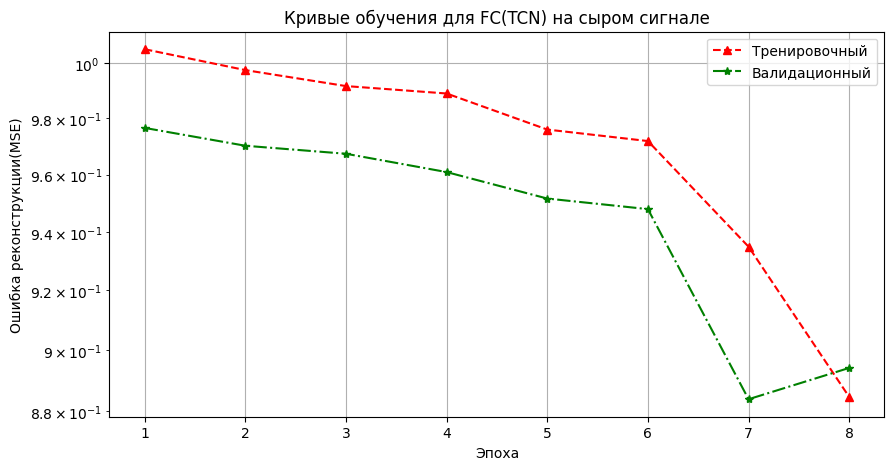

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

epochs_cnt = len(history["train_loss"])

ax.plot(np.arange(1, epochs_cnt + 1), history['train_loss'], ls = '--', c='red', label="Тренировочный", marker="^")
ax.plot(np.arange(1, epochs_cnt + 1), history['val_loss'], ls = '-.', c='green', label="Валидационный", marker="*")

ax.set(title="Кривые обучения для FC(TCN) на сыром сигнале", xlabel="Эпоха", ylabel="Ошибка реконструкции(MSE)", yscale="log")
ax.legend()
ax.grid()
fig.savefig("../pictures/NASAIMS/FC_TCN_raw.png")

# CNN on RAW

In [6]:
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config_forecast")
    print(cfg)

{'data': {'pre_horizon': 1024, 'horizon': 128, 'overlap': 128, 'spectral': False, 'sample_rate': 20000}}


In [7]:
from src.forecasters.datasets import NASAIMSRawForecastDataset, get_nasa_stats
from torch.utils.data import ConcatDataset
from src.cnn import model, load_save
from src.forecasters import train_loop

In [8]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

val_frac = 0.2
val_files = [Path(DATA_PATH) / el for el in files[int(len(files) * healthy_frac) :  int(len(files) * (healthy_frac + val_frac))]]

z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSRawForecastDataset(healthy_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSRawForecastDataset(healthy_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSRawForecastDataset(healthy_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSRawForecastDataset(healthy_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

val_ds0 = NASAIMSRawForecastDataset(val_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
val_ds1 = NASAIMSRawForecastDataset(val_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
val_ds2 = NASAIMSRawForecastDataset(val_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
val_ds3 = NASAIMSRawForecastDataset(val_files, cfg.data.pre_horizon,cfg.data.horizon, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

train_ds = ConcatDataset([ds0, ds1, ds2, ds3])
val_ds = ConcatDataset([val_ds0, val_ds1, val_ds2, val_ds3])

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/295 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/197 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/197 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/197 [00:00<?, ?it/s]

Loading data to RAM:   0%|          | 0/197 [00:00<?, ?it/s]

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
fc_model = model.CNNForecaster(entry_channels = 1, 
                 output_horizon = cfg.data.horizon,
                 n_channels = 16,
                 ch_mults = (1, 2, 4, 8),
                 is_attn = (False, False, True, True),
                 n_blocks = 2).to(device)
epochs = 25
lr = 5e-4
batch_size = 64

optimizer = torch.optim.AdamW(lr=lr, params=fc_model.parameters())

In [11]:
fc_model, history = train_loop.forecast_train_loop(
    model=fc_model,
    train_ds=train_ds,
    test_ds=val_ds,
    optimizer=optimizer,
    epochs=epochs,
    device=device,
    batch_size=batch_size,
    save_func=load_save.save_cnn_fc_checkpoint,
    info_interval=2,
    name="cnn_forecaster"
)

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 2 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 3 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 4 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 5 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 6 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 7 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 8 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 9 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 10 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 11 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 12 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 13 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 14 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 16 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 17 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 18 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 19 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 20 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 21 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 22 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 23 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 24 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 25 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/234 [00:00<?, ?it/s]

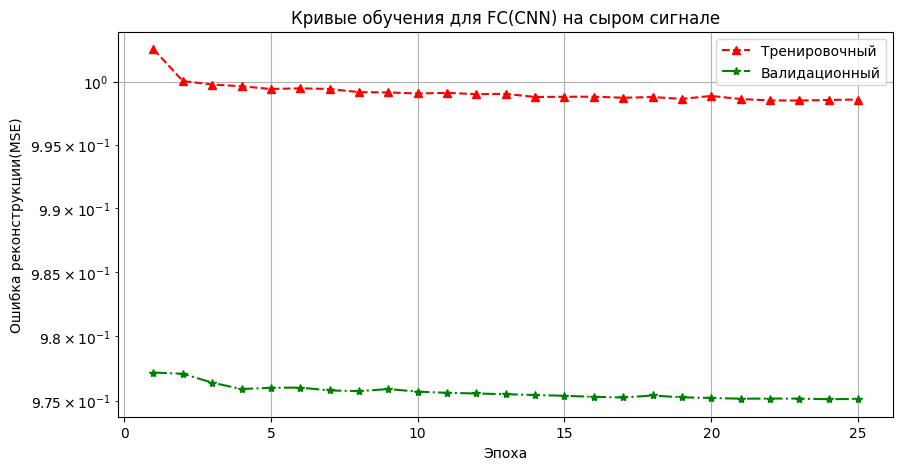

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

epochs_cnt = len(history["train_loss"])

ax.plot(np.arange(1, epochs_cnt + 1), history['train_loss'], ls = '--', c='red', label="Тренировочный", marker="^")
ax.plot(np.arange(1, epochs_cnt + 1), history['val_loss'], ls = '-.', c='green', label="Валидационный", marker="*")

ax.set(title="Кривые обучения для FC(CNN) на сыром сигнале", xlabel="Эпоха", ylabel="Ошибка реконструкции(MSE)", yscale="log")
ax.legend()
ax.grid()
fig.savefig("../pictures/NASAIMS/FC_CNN_raw.png")

In [17]:
pre_horizon, horizon = ds0[0]

with torch.no_grad():
    pred_horizon = fc_model(pre_horizon.to(device).unsqueeze(0)).cpu()

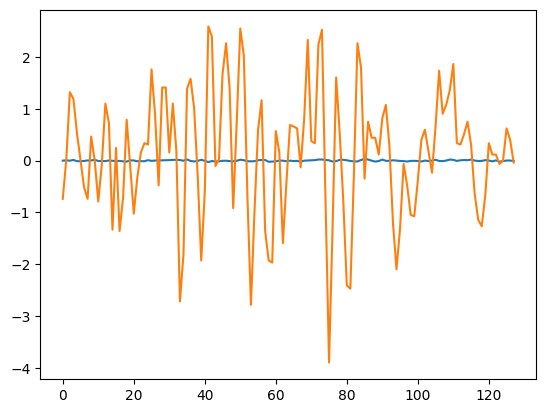

In [23]:
plt.plot(pred_horizon.squeeze(0))
plt.plot(horizon.squeeze(0))

# UNet on Spectrum

In [10]:
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg)

{'data': {'window_size': 1024, 'overlap': 256, 'spectral': False, 'sample_rate': 20000, 'f_max': 5000, 'n_mels': 64, 'chunk_size': 8192, 'chunk_overlap': 6144}}


In [11]:
from src.forecasters.datasets import NASAIMSLongTermSpectrumDataset, get_nasa_stats
from torch.utils.data import ConcatDataset
from src.unet1d import model, load_save
from src.forecasters import train_loop

In [12]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

val_frac = 0.2
val_files = [Path(DATA_PATH) / el for el in files[int(len(files) * healthy_frac) :  int(len(files) * (healthy_frac + val_frac))]]

z_norm_params = get_nasa_stats(healthy_files)
horizon_files = 1

ds0 = NASAIMSLongTermSpectrumDataset(healthy_files, cfg.data.window_size,
                             cfg.data.window_size - cfg.data.overlap,
                             horizon_files, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSLongTermSpectrumDataset(healthy_files, cfg.data.window_size,
                             cfg.data.window_size - cfg.data.overlap,
                             horizon_files, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSLongTermSpectrumDataset(healthy_files, cfg.data.window_size,
                             cfg.data.window_size - cfg.data.overlap,
                             horizon_files, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSLongTermSpectrumDataset(healthy_files, cfg.data.window_size,
                             cfg.data.window_size - cfg.data.overlap,
                             horizon_files, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

val_ds0 = NASAIMSLongTermSpectrumDataset(val_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
val_ds1 = NASAIMSLongTermSpectrumDataset(val_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
val_ds2 = NASAIMSLongTermSpectrumDataset(val_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
val_ds3 = NASAIMSLongTermSpectrumDataset(val_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

train_ds = ConcatDataset([ds0, ds1, ds2, ds3])
val_ds = ConcatDataset([val_ds0, val_ds1, val_ds2, val_ds3])

Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Loading 295 files into RAM...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset initialized: 7644 pairs available.
Prediction Horizon: 1 files ahead.
Loading 295 files into RAM...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset initialized: 7644 pairs available.
Prediction Horizon: 1 files ahead.
Loading 295 files into RAM...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset initialized: 7644 pairs available.
Prediction Horizon: 1 files ahead.
Loading 295 files into RAM...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset initialized: 7644 pairs available.
Prediction Horizon: 1 files ahead.
Loading 197 files into RAM...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset initialized: 5096 pairs available.
Prediction Horizon: 1 files ahead.
Loading 197 files into RAM...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset initialized: 5096 pairs available.
Prediction Horizon: 1 files ahead.
Loading 197 files into RAM...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset initialized: 5096 pairs available.
Prediction Horizon: 1 files ahead.
Loading 197 files into RAM...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset initialized: 5096 pairs available.
Prediction Horizon: 1 files ahead.


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
fc_model = model.UNet1D(n_blocks=1, ch_mults=(1, 2, 2), is_attn=(False, False, True), n_channels=16).to(device)
epochs = 10
lr = 5e-4
batch_size = 32

optimizer = torch.optim.AdamW(lr=lr, params=fc_model.parameters())



fc_model, history = train_loop.forecast_train_loop(fc_model, train_ds, val_ds, optimizer, epochs, device, batch_size, info_interval=2, name="forecast_model_spectrum",
                                                  save_func=load_save.save_model_checkpoint)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 [Train]:   0%|          | 0/956 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/637 [00:00<?, ?it/s]

Epoch 2 [Train]:   0%|          | 0/956 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/637 [00:00<?, ?it/s]

Epoch 3 [Train]:   0%|          | 0/956 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/637 [00:00<?, ?it/s]

Epoch 4 [Train]:   0%|          | 0/956 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/637 [00:00<?, ?it/s]

Epoch 5 [Train]:   0%|          | 0/956 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/637 [00:00<?, ?it/s]

Epoch 6 [Train]:   0%|          | 0/956 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/637 [00:00<?, ?it/s]

Epoch 7 [Train]:   0%|          | 0/956 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/637 [00:00<?, ?it/s]

Epoch 8 [Train]:   0%|          | 0/956 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/637 [00:00<?, ?it/s]

Epoch 9 [Train]:   0%|          | 0/956 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/637 [00:00<?, ?it/s]

Epoch 10 [Train]:   0%|          | 0/956 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/637 [00:00<?, ?it/s]

In [55]:
rand_idx = np.random.randint(len(ds0))
pre_spec, spec = ds2[rand_idx]

with torch.no_grad():
    pred_spec = fc_model(pre_spec.unsqueeze(0).to(device)).cpu()

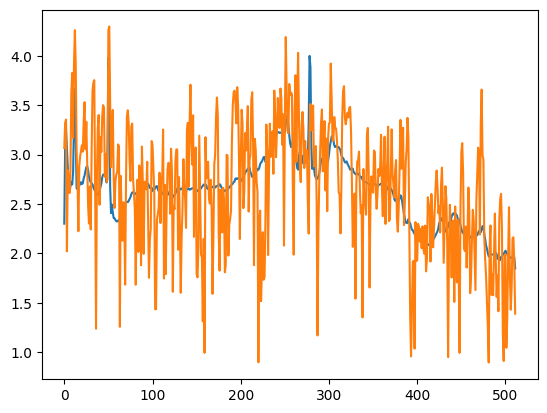

In [56]:
plt.plot(pred_spec[0,0,:])
plt.plot(spec[0,:])

In [58]:
val_end = len(healthy_files) + len(val_files)
horizon = 100
bad_files = [Path(DATA_PATH) / el for el in files[val_end:val_end + horizon]]

In [75]:
num = 0

train_ds = NASAIMSLongTermSpectrumDataset(healthy_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, num, mu=z_norm_params[f"b{num + 1}_mean"], sigma=z_norm_params[f"b{num + 1}_std"])
val_ds = NASAIMSLongTermSpectrumDataset(val_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, num, mu=z_norm_params[f"b{num + 1}_mean"], sigma=z_norm_params[f"b{num + 1}_std"])
test_ds = NASAIMSLongTermSpectrumDataset(bad_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, num, mu=z_norm_params[f"b{num + 1}_mean"], sigma=z_norm_params[f"b{num + 1}_std"])

Loading 295 files into RAM...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset initialized: 22638 pairs available.
Prediction Horizon: 1 files ahead.
Loading 197 files into RAM...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset initialized: 15092 pairs available.
Prediction Horizon: 1 files ahead.
Loading 100 files into RAM...


  0%|          | 0/100 [00:00<?, ?it/s]

Dataset initialized: 7623 pairs available.
Prediction Horizon: 1 files ahead.


In [82]:
rand_idx = np.random.randint(len(test_ds))
pre_spec, spec = test_ds[rand_idx]

with torch.no_grad():
    pred_spec = fc_model(pre_spec.unsqueeze(0).to(device)).cpu()

rand_idx_train = np.random.randint(len(train_ds))
pre_spec_train, spec_train = train_ds[rand_idx_train]

with torch.no_grad():
    pred_spec_train = fc_model(pre_spec_train.unsqueeze(0).to(device)).cpu()

rand_idx_val = np.random.randint(len(val_ds))
pre_spec_val, spec_val = val_ds[rand_idx]

with torch.no_grad():
    pred_spec_val = fc_model(pre_spec_val.unsqueeze(0).to(device)).cpu()

Text(0.5, 1.0, '0.31197232007980347')

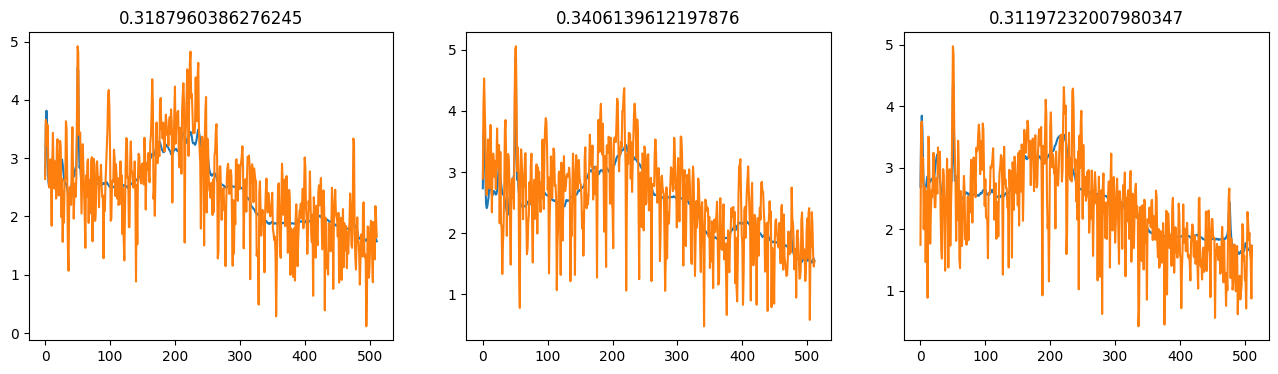

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(pred_spec[0,0,:])
ax[0].plot(spec[0,:])
ax[0].set_title(f"{((spec - pred_spec)**2).mean()}")

ax[1].plot(pred_spec_train[0,0,:])
ax[1].plot(spec_train[0,:])
ax[1].set_title(f"{((spec_train - pred_spec_train)**2).mean()}")

ax[2].plot(pred_spec_val[0,0,:])
ax[2].plot(spec_val[0,:])
ax[2].set_title(f"{((spec_val - pred_spec_val)**2).mean()}")

Text(0.5, 1.0, '0.3391801714897156')

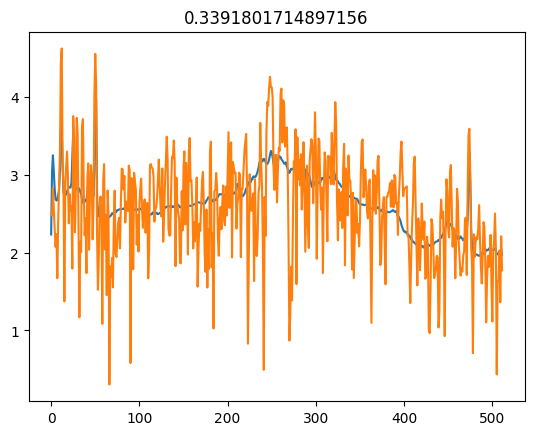